In [20]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.',name='PROTEINS').shuffle()

print(f'Dataset : {dataset}')
print(f'Number of graphs : {len(dataset)}')
print(f'Number of nodes : {dataset[0].x.shape[0]}')
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')

Dataset : PROTEINS(1113)
Number of graphs : 1113
Number of nodes : 31
Number of features : 3
Number of classes : 2


In [ ]:
for i in range(0,5): #확인
    print(dataset[i])
# y=[1] : 노드 분류가 아니라 그래프 분류. (노드 분류라면 x의 갯수와 라벨의 갯수가 동일해야 함)

Data(edge_index=[2, 144], x=[42, 3], y=[1])
Data(edge_index=[2, 52], x=[14, 3], y=[1])
Data(edge_index=[2, 56], x=[20, 3], y=[1])
Data(edge_index=[2, 30], x=[8, 3], y=[1])
Data(edge_index=[2, 74], x=[17, 3], y=[1])


In [14]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

print(f'Training Set : {len(train_dataset)} graphs')
print(f'Val Set : {len(val_dataset)} graphs')
print(f'Test Set : {len(test_dataset)} graphs')

Training Set : 890 graphs
Val Set : 111 graphs
Test Set : 112 graphs


In [15]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

print('Train Loader')
for i,batch in enumerate(train_loader):
    print(f'Batch {i} : {batch}')

print('Val Loader')
for i,batch in enumerate(val_loader):
    print(f'Batch {i} : {batch}')

print('Test Loader')
for i,batch in enumerate(test_loader):
    print(f'Batch {i} : {batch}')


Train Loader
Batch 0 : DataBatch(edge_index=[2, 7294], x=[1973, 3], y=[64], batch=[1973], ptr=[65])
Batch 1 : DataBatch(edge_index=[2, 9678], x=[2664, 3], y=[64], batch=[2664], ptr=[65])
Batch 2 : DataBatch(edge_index=[2, 9174], x=[2397, 3], y=[64], batch=[2397], ptr=[65])
Batch 3 : DataBatch(edge_index=[2, 8778], x=[2372, 3], y=[64], batch=[2372], ptr=[65])
Batch 4 : DataBatch(edge_index=[2, 9684], x=[2650, 3], y=[64], batch=[2650], ptr=[65])
Batch 5 : DataBatch(edge_index=[2, 10856], x=[2960, 3], y=[64], batch=[2960], ptr=[65])
Batch 6 : DataBatch(edge_index=[2, 8166], x=[2132, 3], y=[64], batch=[2132], ptr=[65])
Batch 7 : DataBatch(edge_index=[2, 9232], x=[2480, 3], y=[64], batch=[2480], ptr=[65])
Batch 8 : DataBatch(edge_index=[2, 7600], x=[1990, 3], y=[64], batch=[1990], ptr=[65])
Batch 9 : DataBatch(edge_index=[2, 10478], x=[2745, 3], y=[64], batch=[2745], ptr=[65])
Batch 10 : DataBatch(edge_index=[2, 10654], x=[2863, 3], y=[64], batch=[2863], ptr=[65])
Batch 11 : DataBatch(edge_

In [33]:
import torch
torch.manual_seed(0) #토치의 난수생성 시드 고정
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool

class GIN(torch.nn.Module):
    def __init__(self,dim_h):
        super(GIN,self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.lin1 = Linear(dim_h*3,dim_h*3)
        self.lin2 = Linear(dim_h*3,dataset.num_classes)

    def forward(self,x,edge_index,batch):
        # 노드 임베딩
        h1 = self.conv1(x,edge_index) # 1홉의 정보를 반영한 모든 노드 임베딩
        h2 = self.conv2(h1,edge_index) # 2홉
        h3 = self.conv3(h2,edge_index) # 3홉

        h1 = global_add_pool(h1,batch) # 배치는 그래프의 구분 정보를 암시
        h2 = global_add_pool(h2,batch)
        h3 = global_add_pool(h3,batch)

        #그래프 임베딩으로 표현
        h = torch.cat((h1,h2,h3),dim=1)

        #분류 신경망
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h,p=0.5,training=self.training)
        h = self.lin2(h)
        
        return h


In [34]:
def accuracy(y_pred,y):
    return ((y_pred==y).sum() / len(y)).item()

In [59]:
@torch.no_grad()
def test(model,loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss,acc = 0,0
    batch_size,total_graphs = 0,0
    for data in loader:
        out = model(data.x,data.edge_index,data.batch)
        batch_size = data.num_graphs
        total_graphs+=batch_size
        loss += criterion(out,data.y).item() * batch_size
        acc += accuracy(out.argmax(dim=1),data.y) * batch_size
    
    return loss/total_graphs, acc/total_graphs

In [60]:
def train(model,loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss,total_acc,val_loss,val_acc = 0,0,0,0
        total_graph = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x,data.edge_index,data.batch)
            loss = criterion(out,data.y) # 하나의 로스, 스칼라 값이 나옴. (평균)
            batch_size = data.num_graphs # 배치 크기
            total_graph+=batch_size # 배치 크기 누적
            total_loss += loss.item()*batch_size
            total_acc += accuracy(out.argmax(dim=1),data.y) * batch_size
            loss.backward()
            optimizer.step()

        val_loss,val_acc = test(model,val_loader)
        
        total_loss /= total_graph
        total_acc /= total_graph
        
        if epoch%20==0:
            print(f'Epoch : {epoch:>3} | Train_loss : {total_loss:.3f} | Train_acc : {total_acc*100:.3f} | Val_loss : {val_loss:.3f} | Val_acc : {val_acc*100:.3f}')

    return model            



In [61]:
gin = GIN(dim_h=32)
print(gin)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=2, bias=True)
)


In [62]:
gin_model = train(gin,train_loader)

Epoch :   0 | Train_loss : 1.568 | Train_acc : 59.775 | Val_loss : 0.651 | Val_acc : 62.162
Epoch :  20 | Train_loss : 0.530 | Train_acc : 76.404 | Val_loss : 0.548 | Val_acc : 73.874
Epoch :  40 | Train_loss : 0.511 | Train_acc : 76.180 | Val_loss : 0.508 | Val_acc : 74.775
Epoch :  60 | Train_loss : 0.489 | Train_acc : 76.517 | Val_loss : 0.525 | Val_acc : 74.775
Epoch :  80 | Train_loss : 0.492 | Train_acc : 74.944 | Val_loss : 0.537 | Val_acc : 74.775
Epoch : 100 | Train_loss : 0.467 | Train_acc : 77.416 | Val_loss : 0.516 | Val_acc : 75.676


In [63]:
test_loss, test_acc = test(gin_model,test_loader)
print(f'Test_Loss : {test_loss:.4f} | Test_Acc : {test_acc:.4f}')

Test_Loss : 0.5119 | Test_Acc : 0.7589


GCN 구현

In [94]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
class GCN(torch.nn.Module):

    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return h

In [95]:
gcn = GCN(dim_h=32)
print(gcn)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [96]:
gcn_model = train(gcn,train_loader)

Epoch :   0 | Train_loss : 0.677 | Train_acc : 60.337 | Val_loss : 0.667 | Val_acc : 64.865
Epoch :  20 | Train_loss : 0.608 | Train_acc : 69.326 | Val_loss : 0.617 | Val_acc : 63.964
Epoch :  40 | Train_loss : 0.591 | Train_acc : 71.011 | Val_loss : 0.654 | Val_acc : 66.667
Epoch :  60 | Train_loss : 0.590 | Train_acc : 71.798 | Val_loss : 0.640 | Val_acc : 68.468
Epoch :  80 | Train_loss : 0.589 | Train_acc : 70.112 | Val_loss : 0.647 | Val_acc : 67.568
Epoch : 100 | Train_loss : 0.597 | Train_acc : 70.225 | Val_loss : 0.659 | Val_acc : 63.063


In [97]:
gcn_test_acc, gcn_test_loss = test(gcn_model,test_loader)
print(f'Test_loss : {gcn_test_loss} | Test_acc : {gcn_test_acc}')

Test_loss : 0.660714294229235 | Test_acc : 0.585142161164965


시각화 GIN vs GCN

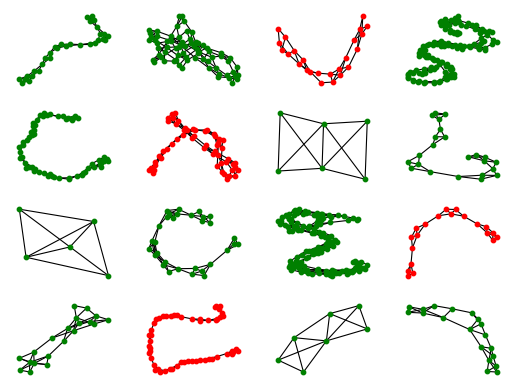

In [100]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig,ax = plt.subplots(4,4)

for i,data in enumerate(dataset[-16:]):
    out = gcn_model(data.x,data.edge_index,data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i,ax.shape) # i를 2D 좌표로 변환
    ax[ix].axis('off') # 축 제거
    G = to_networkx(dataset[i],to_undirected=True) # 방향성 무시
    nx.draw_networkx(G,
                     pos = nx.spring_layout(G,seed=0),
                     with_labels=False,
                     node_size=10,
                     node_color = color,
                     width = 0.8,
                     ax = ax[ix])

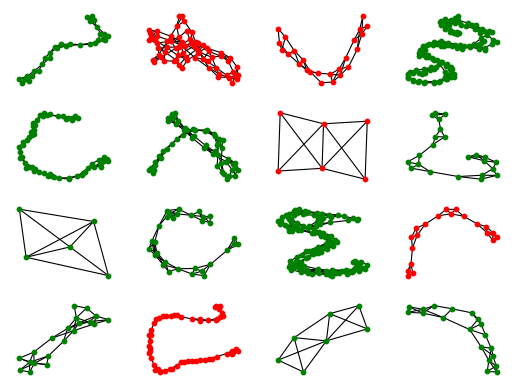

In [101]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig,ax = plt.subplots(4,4)

for i,data in enumerate(dataset[-16:]):
    out = gin_model(data.x,data.edge_index,data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i,ax.shape) # i를 2D 좌표로 변환
    ax[ix].axis('off') # 축 제거
    G = to_networkx(dataset[i],to_undirected=True) # 방향성 무시
    nx.draw_networkx(G,
                     pos = nx.spring_layout(G,seed=0),
                     with_labels=False,
                     node_size=10,
                     node_color = color,
                     width = 0.8,
                     ax = ax[ix])